# Task 1: Dataset Preparation using Python

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import cv2
from PIL import Image
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.image as mpimg

### Goals
1) Get subsets of the COCO dataset as per requirement  
2) Generate masks from the given COCO annotations  
3) Add image augmentations  
4) Create a data generator object to ease training models

In [2]:
dataDir='/home/pavan/working Directory/VJ_Technologies/COCO'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

# initialize the COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.53s)
creating index...
index created!


In [3]:
# display COCO categories and supercategories
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

nms=[cat['name'] for cat in cats]
print(len(nms),'COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print(len(nms),'COCO supercategories: \n{}'.format(' '.join(nms)))

80 COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

12 COCO supercategories: 
indoor electronic furniture animal sports kitchen person appliance food outdoor vehicle accessory


In [4]:
# get all images containing given categories, select one at random
filterClasses = ['laptop', 'tv', 'cell phone']
catIds = coco.getCatIds(catNms=filterClasses);
imgIds = coco.getImgIds(catIds=catIds);

print("Number of images containing all required classes:", len(imgIds))

Number of images containing all required classes: 11


#### Binary Masking

In general,the output mask will _N_ possible pixel values for N output classes. However, binary masking implies that the output mask will have **only 2 pixel values**, i.e., 0 will represent the background and 1 will represent the objects

### 1. Filter the Dataset

The filterDataset function takes 3 inputs-  
(a) **folder**: the folder containing the dataset  
(b) **classes**: a list object if you want specific output classes or None  
(c) **mode**: 'train2017' or 'val2017' 

The function returns-  
a) **images**: a list containing all the filtered image objects  
b) **dataset_size**: The size of the generated filtered dataset  
c) **coco**: The initialized coco object  

### 2. Generate the Image and mask

The dataGeneratorCoco function takes 8 inputs-   
(a) **images**: the image list returned by the filterDataset function  
(b) **classes**: the filter classes list  
(c) **coco**: the coco object returned by the filterDataset function  
(d) **folder**: the folder containing the dataset  
(e) **input_image_size**: size of input image to your model (width, height)  
(f) **batch_size**: batch size  
(g) **mode**: 'train2017' or 'val2017'  
(h) **mask_type**: 'binary' 

The function returns a data generator object yielding batches of images and their corresponding masks

### 3. Making data fo model training

In [5]:
# Define COCO Segmentation Dataset class
class COCOSegmentationDataset(Dataset):
    def __init__(self, data_dir, mode='train2017', input_size=(224, 224), classes=None, mask_type='binary', transforms=None):
        self.data_dir = data_dir
        self.mode = mode
        self.input_size = input_size
        self.classes = classes
        self.mask_type = mask_type
        self.transforms = transforms

        self.annFile = os.path.join(self.data_dir, 'annotations', f'instances_{self.mode}.json')
        self.coco = COCO(self.annFile)

        if self.classes:
            self.catIds = self.coco.getCatIds(catNms=self.classes)
            imgIds = []
            for cid in self.catIds:
                imgIds.extend(self.coco.getImgIds(catIds=cid))
            self.imgs = self.coco.loadImgs(list(set(imgIds)))
        else:
            self.imgs = self.coco.loadImgs(self.coco.getImgIds())

        self.class_to_index = {cls: i + 1 for i, cls in enumerate(self.classes)} if self.classes else {}

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_info = self.imgs[idx]
        img_path = os.path.join(self.data_dir, 'images', self.mode, img_info['file_name'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.input_size)

        annIds = self.coco.getAnnIds(imgIds=img_info['id'], catIds=self.catIds, iscrowd=None)
        anns = self.coco.loadAnns(annIds)

        if self.mask_type == 'binary':
            mask = np.zeros(self.input_size, dtype=np.uint8)
            for ann in anns:
                m = cv2.resize(self.coco.annToMask(ann), self.input_size)
                mask = np.maximum(mask, m)
        elif self.mask_type == 'normal':
            mask = np.zeros(self.input_size, dtype=np.uint8)
            for ann in anns:
                cat_name = self.coco.loadCats(ann['category_id'])[0]['name']
                pixel_value = self.class_to_index.get(cat_name, 0)
                m = cv2.resize(self.coco.annToMask(ann), self.input_size)
                mask = np.maximum(mask, m * pixel_value)
        else:
            raise ValueError("mask_type must be 'binary' or 'normal'")

        # Normalize image and convert to tensors
        img = img.astype(np.float32) / 255.0
        img = torch.from_numpy(img).permute(2, 0, 1)  # [C, H, W]
        mask = torch.from_numpy(mask).long()          # [H, W]

        return img, mask
    
# Parameters
data_dir = '/home/pavan/working Directory/VJ_Technologies/COCO'
input_size = (224, 224)
batch_size = 2
filter_classes = ['laptop', 'tv', 'cell phone']  #filtering the class
mask_type = 'binary'  

# Train and validation datasets for training
train_dataset = COCOSegmentationDataset(data_dir, mode='train2017', input_size=input_size,
                                        classes=filter_classes, mask_type=mask_type)
val_dataset = COCOSegmentationDataset(data_dir, mode='val2017', input_size=input_size,
                                      classes=filter_classes, mask_type=mask_type)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

loading annotations into memory...
Done (t=11.24s)
creating index...
index created!
loading annotations into memory...
Done (t=0.29s)
creating index...
index created!


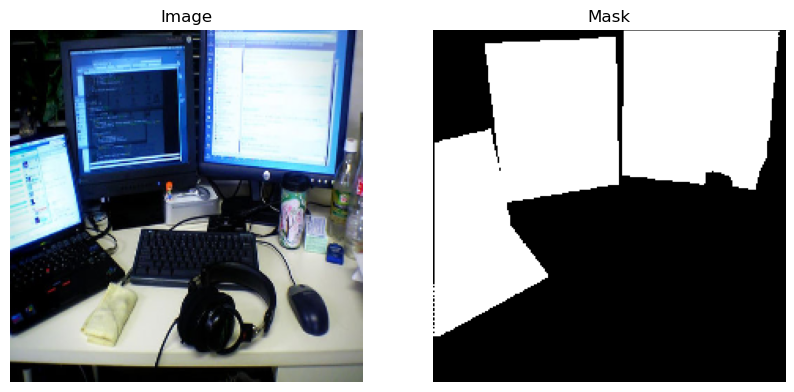

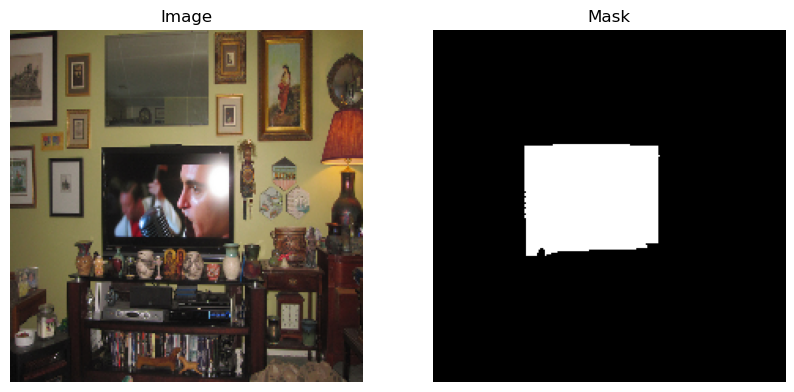

In [6]:
## Visualizing the image
def show_batch(images, masks):
    for i in range(len(images)):
        img = images[i].permute(1, 2, 0).numpy()
        mask = masks[i].numpy()
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")
        plt.axis('off')
        plt.show()

img_batch, mask_batch = next(iter(val_loader))
show_batch(img_batch, mask_batch)

In [7]:
## Save the visualizations
output_dir = '/home/pavan/working Directory/VJ_Technologies/COCO/visualized_images'
os.makedirs(output_dir, exist_ok=True)

# limit the number of visualized images to 5,000.
count = 0
# Loop through the DataLoader for the training or validation set.
for images, masks in tqdm(train_loader, desc="Processing batches"):
    # Loop through each image in the current batch.
    for i in range(images.size(0)):
        if count >= 5000:
            break  # Stop after processing 3000 images
        # Convert tensors to numpy arrays for plotting.
        img = images[i].permute(1, 2, 0).numpy()
        mask = masks[i].numpy()
        
        # Create a figure for each image and its mask.
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")
        plt.axis("off")
        
        # Save the figure as an image file
        plt.savefig(os.path.join(output_dir, f'img_{count:04d}.png'))
        plt.close()
        count += 1
    if count >= 5000:
        break

print(f"Saved {count} image-mask pairs to '{output_dir}'")

Processing batches:  46%|████▌     | 2499/5452 [10:14<12:06,  4.07it/s]  

Saved 5000 image-mask pairs to '/home/pavan/working Directory/VJ_Technologies/COCO/visualized_images'


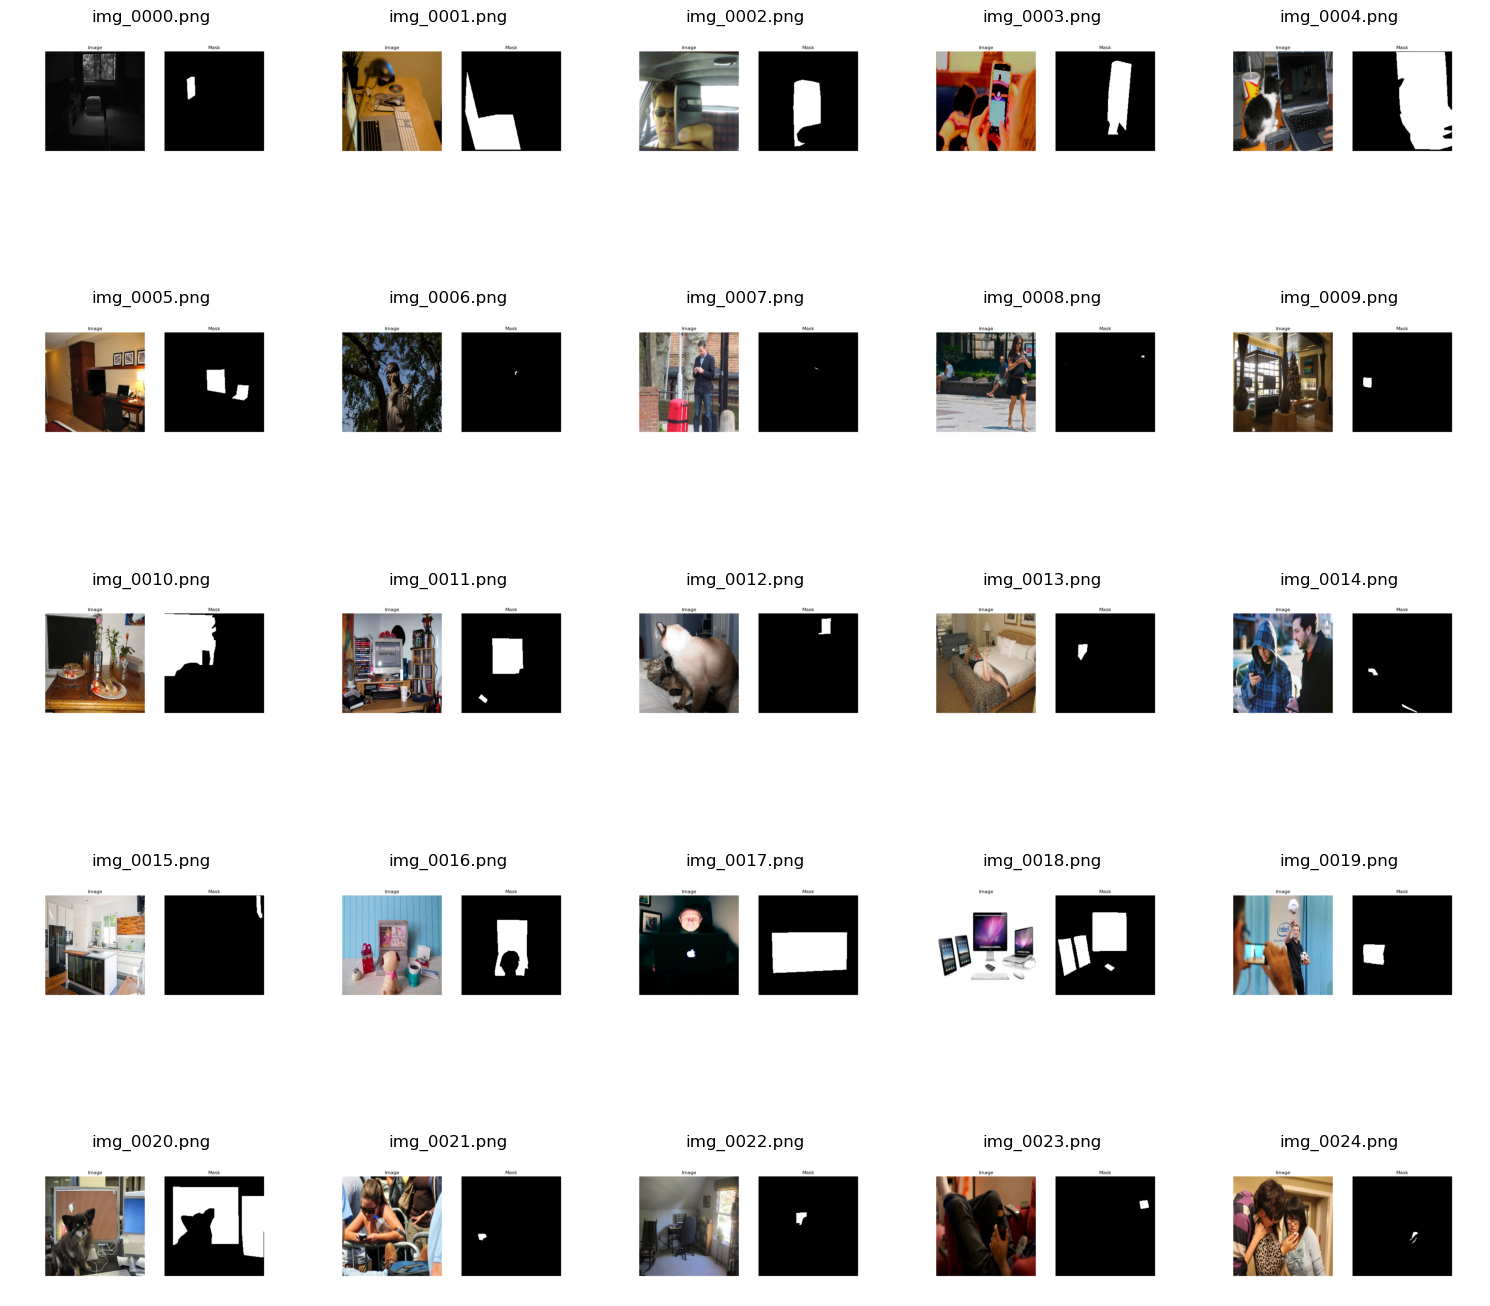

In [8]:
#Displaying images 

image_files = sorted([f for f in os.listdir(output_dir) if f.endswith('.png')])

# Limit the number of images to display (for example, display 25 images in a 5x5 grid)
num_to_display = 25
images_to_plot = image_files[:num_to_display]

# Determine grid size:
grid_size = int(num_to_display**0.5)
if grid_size * grid_size < num_to_display:
    grid_size += 1

fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
axes = axes.flatten()  

for ax, img_file in zip(axes, images_to_plot):
    img_path = os.path.join(output_dir, img_file)
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(img_file)
    ax.axis('off')

# Hide any remaining subplots if the number of images is less than grid cells
for ax in axes[len(images_to_plot):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# TASK 2: Train an Image Segmentation Model

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchviz import make_dot

In [12]:
# Define a class for Unet model for segmentation
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(3, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        # Output layer: single channel + sigmoid for binary segmentation
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((enc4, dec4), dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((enc3, dec3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((enc2, dec2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((enc1, dec1), dim=1)
        dec1 = self.dec1(dec1)

        out = self.final_conv(dec1)
        return self.sigmoid(out)

# Instantiate model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

#save the model
torch.save(model.state_dict(), 'unet_model.pth')
print("Model saved successfully!")

# Load the model
model.load_state_dict(torch.load('unet_model.pth', map_location=device))
model.eval()

print("Model loaded successfully!")

Model saved successfully!
Model loaded successfully!


Epoch 1/10


Epoch [1/10]: 100%|██████████| 5452/5452 [02:15<00:00, 40.26it/s, loss=0.394] 

Train Loss: 0.2847


Validation Loss: 0.3038
Epoch 2/10


Epoch [2/10]: 100%|██████████| 5452/5452 [02:10<00:00, 41.74it/s, loss=0.372] 

Train Loss: 0.2661


Validation Loss: 0.2689
Epoch 3/10


Epoch [3/10]: 100%|██████████| 5452/5452 [01:57<00:00, 46.60it/s, loss=0.145] 

Train Loss: 0.2443


Validation Loss: 0.2535
Epoch 4/10


Epoch [4/10]: 100%|██████████| 5452/5452 [01:57<00:00, 46.55it/s, loss=1.75]  

Train Loss: 0.2264


Validation Loss: 0.2397
Epoch 5/10


Epoch [5/10]: 100%|██████████| 5452/5452 [02:29<00:00, 36.51it/s, loss=0.0329]

Train Loss: 0.2134


Validation Loss: 0.2082
Epoch 6/10


Epoch [6/10]: 100%|██████████| 5452/5452 [01:56<00:00, 46.76it/s, loss=0.541] 

Train Loss: 0.2010


Validation Loss: 0.2118
Epoch 7/10


Epoch [7/10]: 100%|██████████| 5452/5452 [02:17<00:00, 39.65it/s, loss=0.3]   

Train Loss: 0.1906


Validation Loss: 0.2001
Epoch 8/10


Epoch [8/10]: 100%|██████████| 5452/5452 [02:10<00:00, 41.90it/s, loss=0.0832]

Train Loss: 0.1795


Validation Loss: 0.2017
Epoch 9/10


Epoch [9/10]: 100%|██████████| 5452/5452 [02:01<00:00, 45.00it/s, loss=0.787]  

Train Loss: 0.1686


Validation Loss: 0.1794
Epoch 10/10


Epoch [10/10]: 100%|██████████| 5452/5452 [01:49<00:00, 49.84it/s, loss=0.162] 

Train Loss: 0.1574


Validation Loss: 0.1723


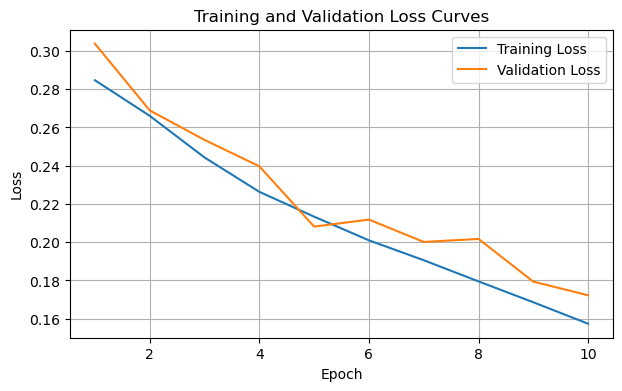

Loss curves saved as loss_curves.png


In [11]:
# --- Loss and optimizer ---
criterion = nn.BCELoss()  # Use BCE for binary segmentation
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# --- Training loop with logging ---
def train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs=10):
    train_loss_list = []
    val_loss_list = []
    
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        print(f"Epoch {epoch+1}/{n_epochs}")
        loop = tqdm(train_loader, total=len(train_loader))

        for images, masks in loop:
            images = images.to(device)
            masks = masks.float().unsqueeze(1).to(device)  # shape: [B, 1, H, W]
            outputs = model(images)                        # sigmoid output
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            loop.set_description(f"Epoch [{epoch+1}/{n_epochs}]")
            loop.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)
        train_loss_list.append(avg_train_loss)
        print(f"Train Loss: {avg_train_loss:.4f}")

        # --- Validation ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.float().unsqueeze(1).to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_loss_list.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.4f}")

    # --- Visualization of Loss Curves ---
    plt.figure(figsize=(7,4))
    plt.plot(range(1, n_epochs + 1), train_loss_list, label='Training Loss')
    plt.plot(range(1, n_epochs + 1), val_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.savefig("loss_curves.png")
    plt.show()
    print("Loss curves saved as loss_curves.png")

# --- Run training ---
train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs=10)


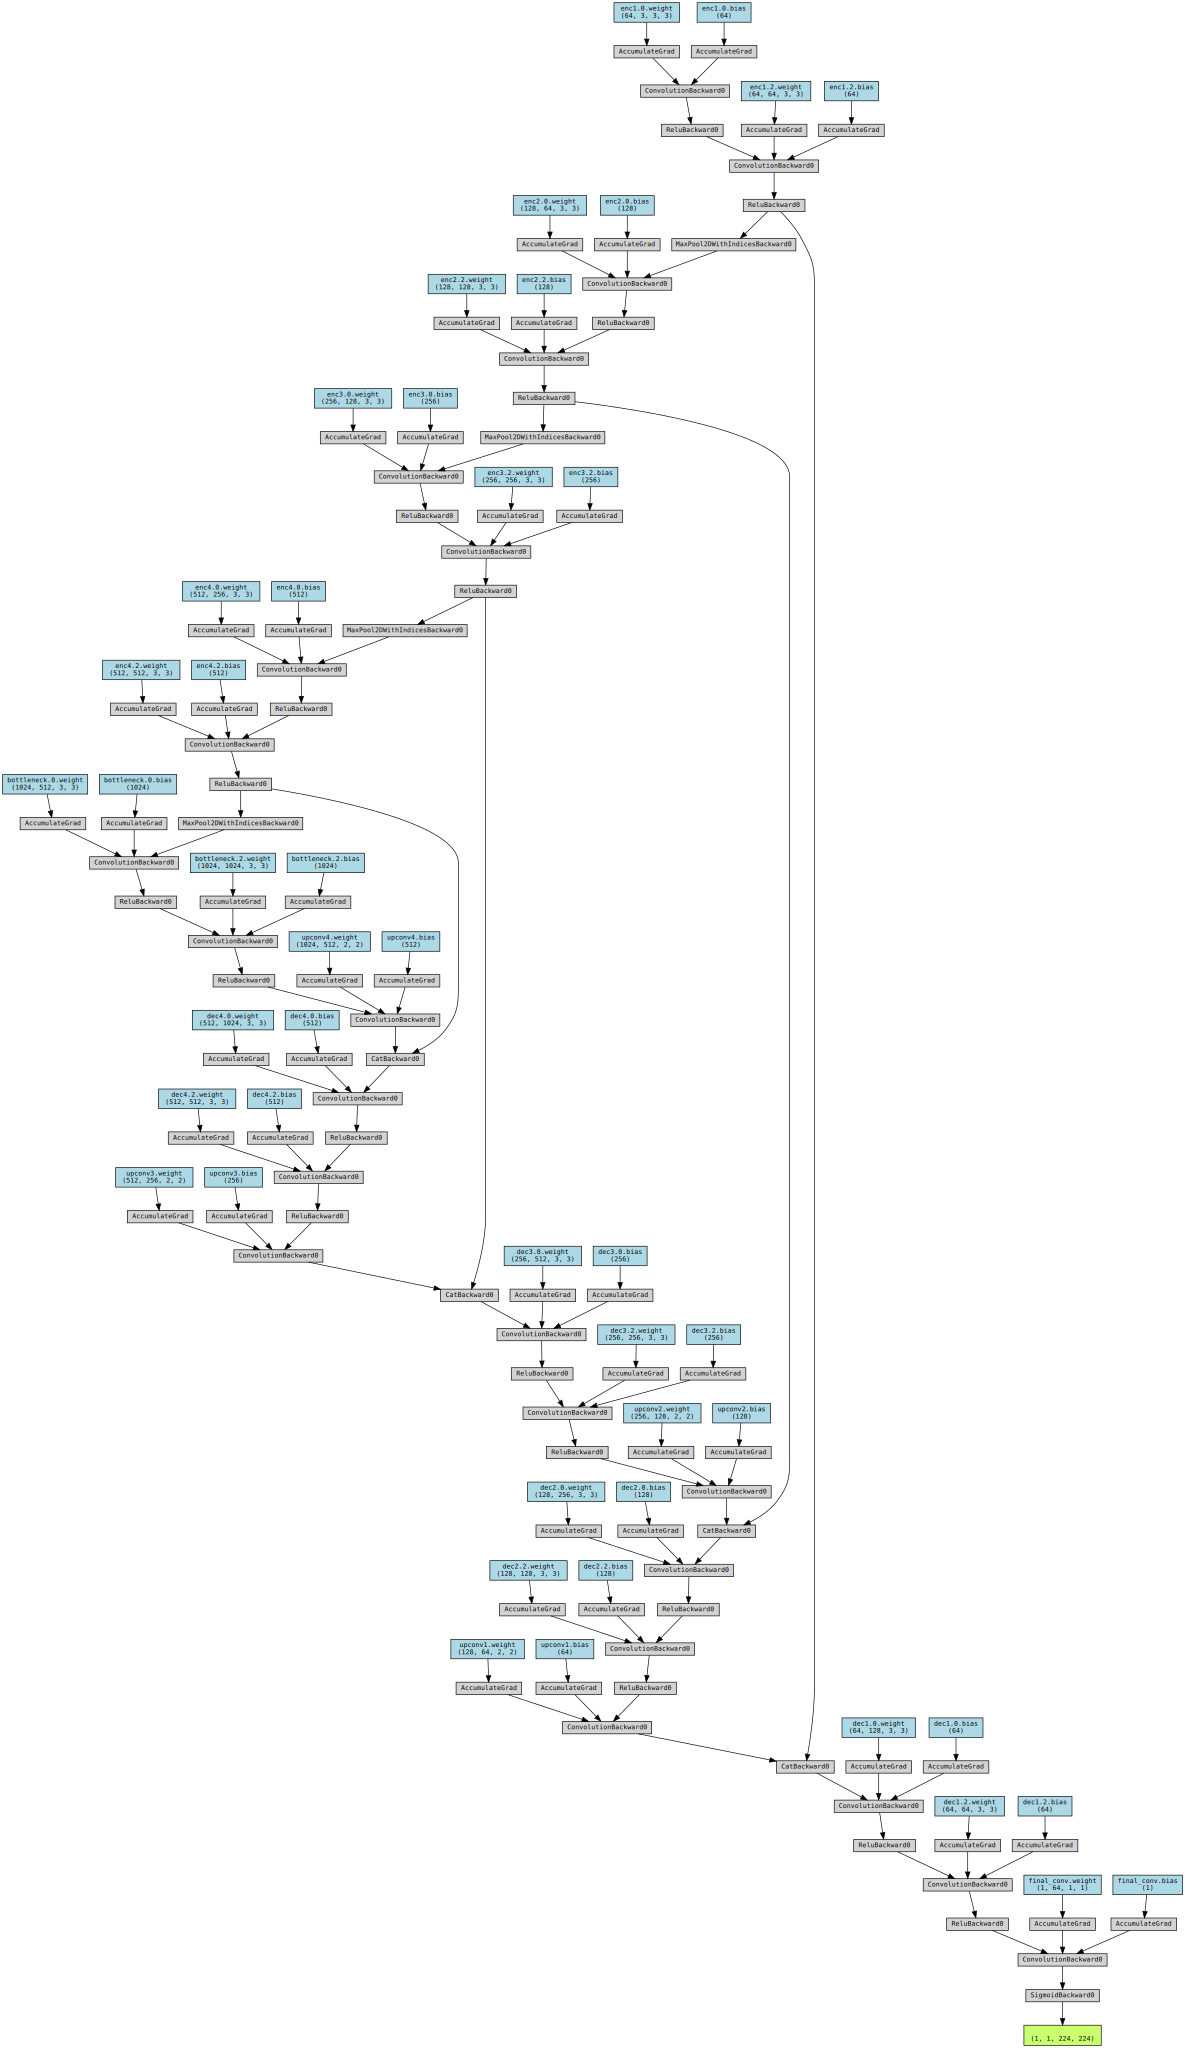

In [ ]:
## Visulaizing the Unet architecture for dummy input
# Create a dummy input (batch_size=1, 3 color channels, image size 224x224)
dummy_input = torch.randn(1, 3, 224, 224, device=device)

# Forward pass (dummy input)
output = model(dummy_input)

# Generate the computation graph using torchviz
graph = make_dot(output, params=dict(model.named_parameters()))

# Save the generated graph as a PNG file
graph.render("unet_architecture", format="png")

graph